# Load Preprocessed Data

In [ ]:
# importing Libraries
import pandas as pd
import numpy as np
import warnings

# Suppress warnings to keep the output cleaner.
warnings.filterwarnings('ignore')

# Read the CSV file into a Pandas DataFrame.
df = pd.read_csv("/content/processed_data.csv")

# Identify significant spikes in sales
threshold = df["Items_Qty_In_Grams"].quantile(0.95)  # Define a threshold (95th percentile as an example)
promotional_periods = df[df["Items_Qty_In_Grams"] > threshold]

# Mark promotional periods
df["is_promotional"] = 0
df.loc[df["Items_Qty_In_Grams"] > threshold, "is_promotional"] = 1

# Display the first 5 rows of the DataFrame.
df.head()

,date,pizza_id,order_id,pizza_name_id,quantity,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,...,Year,Month,Day,Hour,Minute,Second,Items_Qty_In_Grams,day_of_week,is_weekend,is_promotional
0,2015-01-01 11:38:36,1,1,27,1,13.25,13.25,1,1,55,...,2015,1,1,11,38,36,33.402357,3,0,0
1,2015-01-01 11:38:36,1,1,27,1,13.25,13.25,1,1,46,...,2015,1,1,11,38,36,30.000000,3,0,0
2,2015-01-01 11:38:36,1,1,27,1,13.25,13.25,1,1,36,...,2015,1,1,11,38,36,20.000000,3,0,0
3,2015-01-01 11:57:40,6,2,80,1,20.75,20.75,0,0,46,...,2015,1,1,11,57,40,45.000000,3,0,0
4,2015-01-01 11:57:40,5,2,42,1,16.00,16.00,1,3,25,...,2015,1,1,11,57,40,10.000000,3,0,0


In [ ]:
df['date'] = pd.to_datetime(df['date'])

def prepare_weekly_sales(df1):
    df1['date'] = df1['date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales = df1.groupby('date')['quantity'].sum().reset_index()    # Group by weekly periods and sum the quantity
    return weekly_sales

df_weekly = prepare_weekly_sales(df)
df_weekly.set_index('date', inplace=True)
df_weekly.head()

,quantity
date,
2014-12-29,3027
2015-01-05,5525
2015-01-12,4648
2015-01-19,4907
2015-01-26,4803


# Model Building & Selection

## Checking Stationarity

**The Augmented Dickey-Fuller (ADF) test is a statistical test that determines if a time series is stationary.**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity using the Augmented Dickey-Fuller (ADF) test.
result = adfuller(df_weekly['quantity']) # Apply ADF test to the 'quantity' column.
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}, Lags used: {result[2]}, No. of observations used: {result[3]}")

# Interpret the results of the ADF test.
if result[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

ADF Statistic: -5.661242371385048, p-value: 9.36925241209289e-07, Lags used: 0, No. of observations used: 52
Interpretation: The original series is Stationary.



The output indicates that your time series is stationary. Here's a breakdown:

- **ADF Statistic: -5.66**: This is a very low value, meaning the test statistic is well below the critical values typically used.

- **p-value: 9.37e-07**: This p-value is far below the common significance threshold of 0.05, leading us to reject the null hypothesis of a unit root.

- **Lags used: 0**: The test determined that no lagged differences were needed, which is acceptable given data structure.

- **No. of observations used: 52**: Test was conducted on 52 observations, which seems reasonable depending on data frequency.

## MAPE (Mean Absolute Percentage Error)

In [ ]:
# MAPE
def mean_absolute_percentage_error(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

## ARIMA MODEL

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Ensure index is a datetime index
df_weekly.index = pd.to_datetime(df_weekly.index)

# Split data into train and test
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Optionally, set a weekly frequency for both train and test if not already set
train.index = pd.date_range(start=train.index[0], periods=len(train), freq="W")
test.index = pd.date_range(start=test.index[0], periods=len(test), freq="W")

# Auto ARIMA to determine best (p,d,q)
auto_arima_model = auto_arima(train, seasonal=False, stepwise=True)
best_order = auto_arima_model.order
print(f"Best ARIMA Order: {best_order}")

# Fit ARIMA model
arima_model = ARIMA(train, order=(best_order))
arima_result = arima_model.fit()

# Make predictions
forecast_result = arima_result.get_forecast(steps=len(test))
predictions = forecast_result.summary_frame()["mean"].copy()  # Ensure it's a copy
predictions.index = test.index  # Manually align index with test set

# Compute and print error metric
m = mean_absolute_percentage_error(test.values, predictions.values)
print(f"Mean Absolute Percentage Error (MAPE): {m:.2f}%")

Best ARIMA Order: (0, 0, 1)
Mean Absolute Percentage Error (MAPE): 21.88%


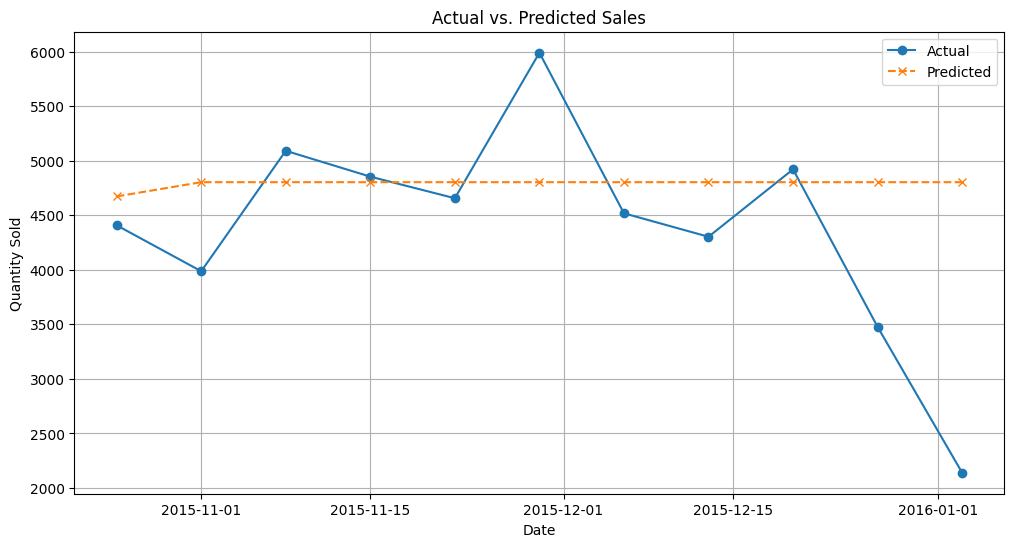

In [ ]:
import matplotlib.pyplot as plt

# Plot Actual vs. Predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, marker='o', linestyle='-', label='Actual')
plt.plot(predictions.index, predictions, marker='x', linestyle='--', label='Predicted')

plt.title("Actual vs. Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.show()

## SARIMA MODEL

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train SARIMA model on weekly data with annual seasonality (52 weeks)
model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),  # Change seasonal period to 52 for annual seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

# Make predictions
forecast_result = results.get_forecast(steps=len(test))
predictions = forecast_result.summary_frame()["mean"].copy()  # Ensure it's a copy
predictions.index = test.index  # Manually align index with test set

# Compute and print error metric
m = mean_absolute_percentage_error(test.values, predictions.values)
print(f"Mean Absolute Percentage Error (MAPE): {m:.2f}%")

Mean Absolute Percentage Error (MAPE): 35.08%


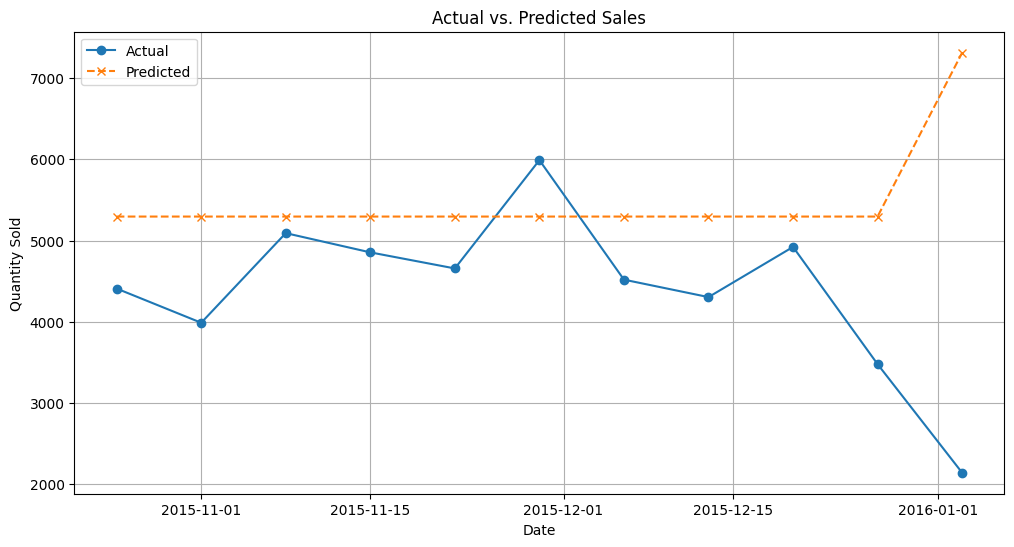

In [ ]:
import matplotlib.pyplot as plt

# Plot Actual vs. Predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, marker='o', linestyle='-', label='Actual')
plt.plot(predictions.index, predictions, marker='x', linestyle='--', label='Predicted')

plt.title("Actual vs. Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.show()

## Prophet Model

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet

# Split data into train and test
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Reset indices if needed
train = train.reset_index()
test = test.reset_index()

# Rename columns to Prophet’s expected names
train = train.rename(columns={"date": "ds", "quantity": "y"})
test = test.rename(columns={"date": "ds", "quantity": "y"})

# Initialize and fit Prophet model
model = Prophet(weekly_seasonality=True)
model.fit(train)

# Use test set dates instead of make_future_dataframe
future = test[['ds']].copy()
forecast = model.predict(future)

# Align forecast with test set
forecast.set_index('ds', inplace=True)
test.set_index('ds', inplace=True)

predictions = forecast['yhat'].reindex(test.index)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmqsigr0k/9xjhqaww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmqsigr0k/02xvcff9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26831', 'data', 'file=/tmp/tmpmqsigr0k/9xjhqaww.json', 'init=/tmp/tmpmqsigr0k/02xvcff9.json', 'output', 'file=/tmp/tmpmqsigr0k/prophet_model2r9u703i/prophet_model-20250218054215.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:42:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:42:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Compute and print error metric
m = mean_absolute_percentage_error(test.values, predictions.values)
print(f"Mean Absolute Percentage Error (MAPE): {m:.2f}%")

Mean Absolute Percentage Error (MAPE): 21.95%


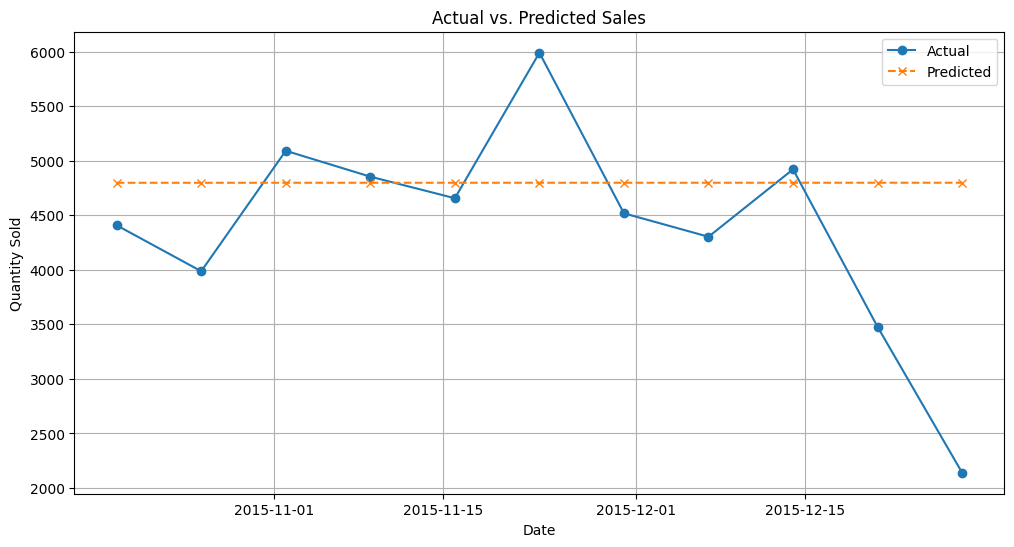

In [ ]:
import matplotlib.pyplot as plt

# Plot Actual vs. Predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, marker='o', linestyle='-', label='Actual')
plt.plot(predictions.index, predictions, marker='x', linestyle='--', label='Predicted')

plt.title("Actual vs. Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.show()

## LSTM Model

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df_weekly = df.copy()
df_weekly['date'] = pd.to_datetime(df_weekly['date'])
df_weekly.set_index('date', inplace=True)
df_weekly = df_weekly.groupby(df_weekly.index)[['quantity', 'is_weekend', 'is_promotional']].sum()

# Resample to weekly frequency and sum the values for numeric columns.
df_weekly = df_weekly.resample('W').sum()

# Recalculate 'day_of_week' for each weekly period using the day of week of the period's start.
df_weekly['day_of_week'] = df_weekly.index.dayofweek

# Split into Training and Testing Sets
train_size = int(len(df_weekly) * 0.8)
train = df_weekly.iloc[:train_size].copy()
test = df_weekly.iloc[train_size:].copy()
train.reset_index(inplace=True)
test.reset_index(inplace=True)

# Scaling
# We'll forecast 'quantity' and use three exogenous features: 'is_weekend', 'is_promotional', and 'day_of_week'.
exog_features = ['is_weekend', 'is_promotional', 'day_of_week']

# Scale the target (quantity) separately.
target_scaler = MinMaxScaler(feature_range=(0, 1))
train_target_scaled = target_scaler.fit_transform(train[['quantity']])
test_target_scaled = target_scaler.transform(test[['quantity']])

# Scale the exogenous features separately.
exog_scaler = MinMaxScaler(feature_range=(0, 1))
train_exog_scaled = exog_scaler.fit_transform(train[exog_features])
test_exog_scaled = exog_scaler.transform(test[exog_features])

# Combine scaled target and exogenous features.
# We place 'quantity' as the first column.
train_scaled = np.hstack([train_target_scaled, train_exog_scaled])
test_scaled = np.hstack([test_target_scaled, test_exog_scaled])

# Create Sequences for LSTM
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        # The target is the scaled quantity (first column) at time t + look_back
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 4  # number of time steps (weeks) to use as input
X_train_seq, y_train_seq = create_sequences(train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(test_scaled, look_back)

# Build and Train the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, train_scaled.shape[1])))
model.add(Dense(1))  # Predict the next week's scaled quantity
model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

# Forecast and Evaluate
y_pred_scaled = model.predict(X_test_seq)

# Inverse transform the scaled predictions and true values back to the original scale.
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Evaluate the model using MAPE
m = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {m:.2f}%")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 936ms/step - loss: 96.1827 - val_loss: 88.4252
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 89.5233 - val_loss: 81.4932
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 82.0308 - val_loss: 74.3636
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 75.2456 - val_loss: 69.6133
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 70.1204 - val_loss: 69.5881
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 64.6477 - val_loss: 69.7729
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 58.5575 - val_loss: 69.9973
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 53.0237 - val_loss: 70.3540
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 49.3321 - val_loss: 71.0111
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 40.7516 - val_loss: 74.8023
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 34.3563 - val_loss: 82.6579
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss:

### Xgboost Model

Prepare data for Training

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Assume df is already defined.
# Make a copy of the original DataFrame
df_weekly = df.copy()

# Ensure the 'date' column is datetime and set it as index
df_weekly['date'] = pd.to_datetime(df_weekly['date'])
df_weekly.set_index('date', inplace=True)

# Group data by date and aggregate. For numeric columns use sum.
# For 'day_of_week', summing is not meaningful so we drop it here and recalculate later.
df_weekly = df_weekly.groupby(df_weekly.index)[['quantity', 'is_weekend', 'is_promotional']].sum()

# Resample to weekly frequency and sum the values for numeric columns.
df_weekly = df_weekly.resample('W').sum()

# Recalculate 'day_of_week' for each weekly period (using the start of the period).
df_weekly['day_of_week'] = df_weekly.index.dayofweek

# Split data into train and test sets (first 80% for training, remaining 20% for testing)
train_size = int(len(df_weekly) * 0.8)
train = df_weekly.iloc[:train_size].copy()
test = df_weekly.iloc[train_size:].copy()

# Reset index to turn the datetime index into a column
train.reset_index(inplace=True)
test.reset_index(inplace=True)

# Prepare training and testing data (features and target)
# Drop both 'quantity' and 'date' columns from the features
X_train = train.drop(columns=['quantity', 'date'])
y_train = train['quantity']
X_test = test.drop(columns=['quantity', 'date'])
y_test = test['quantity']

Train The Xgboost Model

In [ ]:
# Convert data to DMatrix (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define a custom MAPE evaluation function for XGBoost
def mape(y_pred, dtrain):
    y_true = dtrain.get_label()
    # Avoid division by zero by considering only non-zero true values
    nonzero_mask = y_true != 0
    if np.sum(nonzero_mask) == 0:
        return 'mape', np.inf  # Alternatively, return 0 if preferred
    mape_value = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100
    return 'mape', mape_value

# Define model parameters
params = {
    'objective': 'reg:squarederror',  # Regression with squared error loss
    'eval_metric': 'rmse',             # RMSE evaluation metric
    'learning_rate': 0.01,
    'max_depth': 5,
    'seed': 42
}

# Train the XGBoost model with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'eval')],
    feval=mape,
    early_stopping_rounds=10
)

# Optionally, evaluate MAPE on the training set:
train_mape = mape(model.predict(dtrain), dtrain)
print(f"Training MAPE: {train_mape[1]: .2f}%")

[0]	eval-rmse:1017.40995	eval-mape:21.85769
[1]	eval-rmse:1013.66375	eval-mape:21.78631
[2]	eval-rmse:1009.95154	eval-mape:21.71548
[3]	eval-rmse:1006.27308	eval-mape:21.64519
[4]	eval-rmse:1002.62811	eval-mape:21.57543
[5]	eval-rmse:999.02993	eval-mape:21.50448
[6]	eval-rmse:995.45001	eval-mape:21.43577
[7]	eval-rmse:991.91631	eval-mape:21.36588
[8]	eval-rmse:988.40050	eval-mape:21.29821
[9]	eval-rmse:984.91678	eval-mape:21.23106
[10]	eval-rmse:981.47772	eval-mape:21.16273
[11]	eval-rmse:978.05664	eval-mape:21.09659
[12]	eval-rmse:974.67947	eval-mape:21.02928
[13]	eval-rmse:971.31994	eval-mape:20.96415
[14]	eval-rmse:968.00366	eval-mape:20.89784
[15]	eval-rmse:964.70472	eval-mape:20.83370
[16]	eval-rmse:961.43606	eval-mape:20.77004
[17]	eval-rmse:958.20904	eval-mape:20.70521
[18]	eval-rmse:954.99928	eval-mape:20.64251
[19]	eval-rmse:951.83062	eval-mape:20.57865
[20]	eval-rmse:948.57613	eval-mape:20.51588
[21]	eval-rmse:945.35029	eval-mape:20.45357
[22]	eval-rmse:942.15292	eval-mape:20

# Final Evaluation

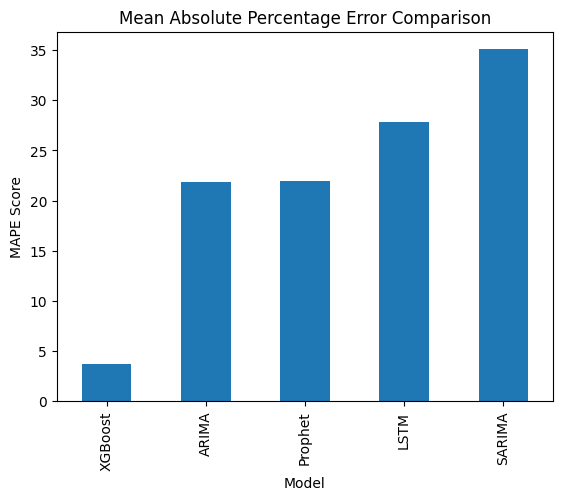

,Model,MAPE
Rank,,
1.0,XGBoost,3.74
2.0,ARIMA,21.88
3.0,Prophet,21.95
4.0,LSTM,27.83
5.0,SARIMA,35.08


In [ ]:
result_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'LSTM', 'XGBoost'],
    'MAPE': [21.88, 35.08, 21.95, 27.83, 3.74]})
result_df['Rank'] = result_df['MAPE'].rank()
result_df = result_df.sort_values('MAPE', ascending=True)
result_df.set_index('Rank', inplace=True)
result_df.plot(x='Model', y='MAPE', kind='bar', title='Mean Absolute Percentage Error Comparison', legend=False)
plt.xlabel('Model')
plt.ylabel('MAPE Score')
plt.show()
result_df

# Predict Next week's sales

In [ ]:
# Get the last date from your weekly DataFrame
last_date = df_weekly.index[-1]

# Calculate next week's date (assuming weekly frequency)
next_week_date = last_date + pd.Timedelta(weeks=1)

next_week_features = {
    'day_of_week': next_week_date.dayofweek,
    'is_weekend': 1 if next_week_date.dayofweek >= 5 else 0,
    'is_promotional': 0  # Change this if you have promotional info for next week.
}